In [ ]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import sklearn
import cv2
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import datetime
import io
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import L1,L2

import wandb
# from wandb import WandbCallback


Wandb, Install, Login and Initilization

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 kB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.6 MB/s eta 0:00:00


In [ ]:
!wandb login


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
Aborted!


In [ ]:
import wandb
wandb.login()


wandb: Currently logged in as: neupaneriwaj64 (riwaj_neupane). Use `wandb login --relogin` to force relogin


True

In [ ]:
# Start a run, tracking hyperparameters
wandb.init(
    # set the wandb project where this run will be logged
    project="my-awesome-project",

)

NameError: name 'wandb' is not defined

In [ ]:
wandb.config = {
    "LEARNING_RATE":0.001,
    "N_EPOCHS":100,
    "BATCH_SIZE":128,
    "DROPOUT_RATE":0.0,
    "IM_SIZE": 224,
    "REGULARIZATION_RATE":0.0,
    "N_FILTERS":6,
    "KERNEL_SIZE":3,
    "N_STRIDES":1,
    "POOL_SIZE":2,
    "N_DENSE_1":128,
    "N_DENSE2":32
}

In [ ]:
!wandb login


wandb: Currently logged in as: neupaneriwaj64 (riwaj_neupane). Use `wandb login --relogin` to force relogin


In [ ]:
wandb.run

Data Loading

In [ ]:
dataset, dataset_info = tfds.load('malaria',
                                  with_info = True,
                                  as_supervised= True,
                                  shuffle_files= True,
                                  split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteE8B7R2/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [ ]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)
  train_dataset = dataset.take(int(TRAIN_RATIO* DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO* DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO * DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO * DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [ ]:

TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

# dataset = tf.data.Dataset.range(10)
train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
print(list(train_dataset.take(1).as_numpy_iterator()),
      list(val_dataset.take(1).as_numpy_iterator()),list(test_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 0)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

In [ ]:
dataset


[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

Data Visualization

(-0.5, 153.5, 132.5, -0.5)

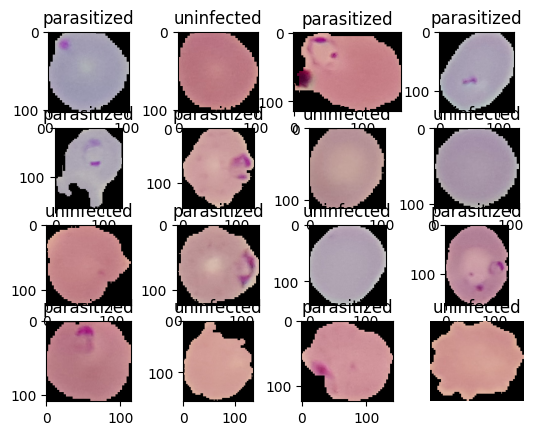

In [ ]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
plt.axis('off')

In [ ]:
dataset_info.features['label'].int2str(1)


'uninfected'

Data Preprocessing

In [ ]:

IM_SIZE = 224
def resize_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [ ]:
train_dataset =  train_dataset.map(resize_rescale)
val_dataset =  val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)
train_dataset


<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:

for data in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]], shape=(133, 154, 3), dtype=uint8) tf.Tensor(1, shape=(), dtype=int64)


In [ ]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [ ]:
val_dataset = val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


Sequential API

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report, precision_recall_curve
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, InputLayer, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import wandb
from wandb.keras import WandbCallback

ModuleNotFoundError: No module named 'wandb.keras'

In [ ]:
wandb.init(project="Malaria", entity="neuralearn")


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


CommError: It appears that you do not have permission to access the requested resource. Please reach out to the project owner to grant you access. If you have the correct permissions, verify that there are no issues with your networking setup.(Error 403: Forbidden)

In [ ]:
config = wandb.config
config.update({
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 100,
    "BATCH_SIZE": 128,
    "DROPOUT_RATE": 0.3,
    "IM_SIZE": 224,
    "REGULARIZATION_RATE": 0.3,
    "N_FILTERS": [6, 16],
    "KERNEL_SIZE": [3, 3],
    "N_STRIDES": [1, 1],
    "POOL_SIZE": [2, 2],
    "N_DENSE_1": 128,
    "N_DENSE_2": 32
})

In [ ]:
# Define the LeNet model
lenet_model = Sequential([
    InputLayer(input_shape=(config['IM_SIZE'], config['IM_SIZE'], 3)),
    Conv2D(filters=config['N_FILTERS'][0], kernel_size=config['KERNEL_SIZE'][0], strides=config['N_STRIDES'][0], padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=config['POOL_SIZE'][0], strides=config['N_STRIDES'][0]),

    Conv2D(filters=config['N_FILTERS'][1], kernel_size=config['KERNEL_SIZE'][1], strides=config['N_STRIDES'][1], padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=config['POOL_SIZE'][1], strides=config['N_STRIDES'][1]),
    Flatten(),
    Dense(config['N_DENSE_1'], activation='relu'),
    Dropout(config['DROPOUT_RATE']),
    Dense(config['N_DENSE_2'], activation='relu'),
    Dropout(config['DROPOUT_RATE']),
    Dense(1, activation='sigmoid')
])


In [ ]:
lenet_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_20 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 221, 221, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 219, 219, 16)      880       
                                                                 
 batch_normalization_21 (Ba  (None, 219, 219, 16)      64        
 tchNormalization)                                               
                                                      

In [ ]:
# Compile the model
lenet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=config['LEARNING_RATE']),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [ ]:
# Train the model with early stopping and WandbCallback
history = lenet_model.fit(train_dataset,
                          validation_data=val_dataset,
                          epochs=config['N_EPOCHS'],
                          verbose=1,
                          callbacks=[early_stopping])

Epoch 1/100
689/689 [==============================] - 83s 108ms/step - loss: 4.1930 - accuracy: 0.5181 - val_loss: 0.6933 - val_accuracy: 0.4966
Epoch 2/100
689/689 [==============================] - 62s 90ms/step - loss: 0.9033 - accuracy: 0.5068 - val_loss: 0.6930 - val_accuracy: 0.4951
Epoch 3/100
689/689 [==============================] - 63s 91ms/step - loss: 0.7367 - accuracy: 0.4967 - val_loss: 0.6932 - val_accuracy: 0.4951
Epoch 4/100
689/689 [==============================] - 64s 93ms/step - loss: 0.7131 - accuracy: 0.4965 - val_loss: 0.6931 - val_accuracy: 0.5074
Epoch 5/100
689/689 [==============================] - 69s 100ms/step - loss: 0.7123 - accuracy: 0.4987 - val_loss: 0.6931 - val_accuracy: 0.5053
Epoch 6/100
689/689 [==============================] - 69s 100ms/step - loss: 0.7583 - accuracy: 0.4998 - val_loss: 0.6931 - val_accuracy: 0.4966
Epoch 7/100
689/689 [==============================] - 70s 102ms/step - loss: 0.7023 - accuracy: 0.4979 - val_loss: 0.6931 - va

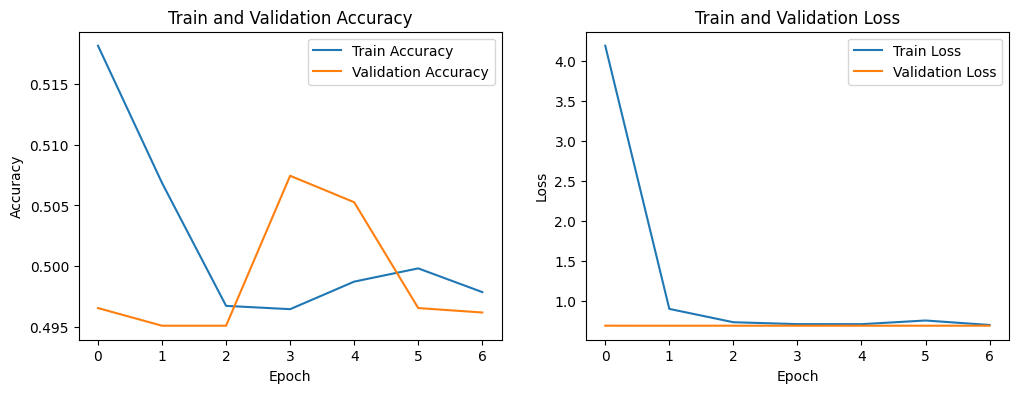

In [ ]:
# Plotting accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss')

plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


def calculate_metrics_and_plot_confusion_matrix(model, test_data, class_names):
    # Predict probabilities for the test set
    y_probs = model.predict(test_data)
    # Predict labels for the test set
    y_preds = np.argmax(y_probs, axis=1)

    # Get true labels
    true_labels = []
    for _, y_true in test_data.unbatch():
        true_labels.append(y_true.numpy().argmax())

    # Calculate precision
    precision = precision_score(true_labels, y_preds, average='macro')
    # Calculate recall
    recall = recall_score(true_labels, y_preds, average='macro')
    # Calculate F1 score
    f1 = f1_score(true_labels, y_preds, average='macro')
    # Calculate confusion matrix
    conf_mat = confusion_matrix(true_labels, y_preds)

    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Confusion Matrix:\n", conf_mat)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()



87/87 [==============================] - 16s 42ms/step
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[2755]]


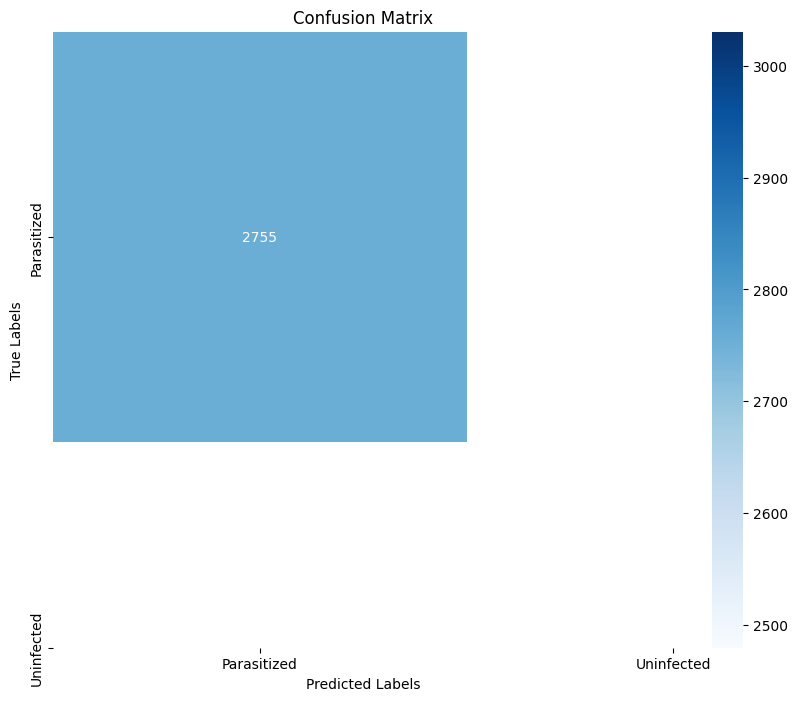

In [ ]:
results_0 = calculate_metrics_and_plot_confusion_matrix(lenet_model, val_dataset, labels)
results_0

In [ ]:
labels = ['Parasitized', 'Uninfected']

In [ ]:
# Predict probabilities for validation data
val_probs = lenet_model.predict(val_dataset)
val_labels = np.concatenate([y for x, y in val_dataset], axis=0)

87/87 [==============================] - 22s 35ms/step


In [ ]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(val_labels, val_probs)
roc_auc = roc_auc_score(val_labels, val_probs)

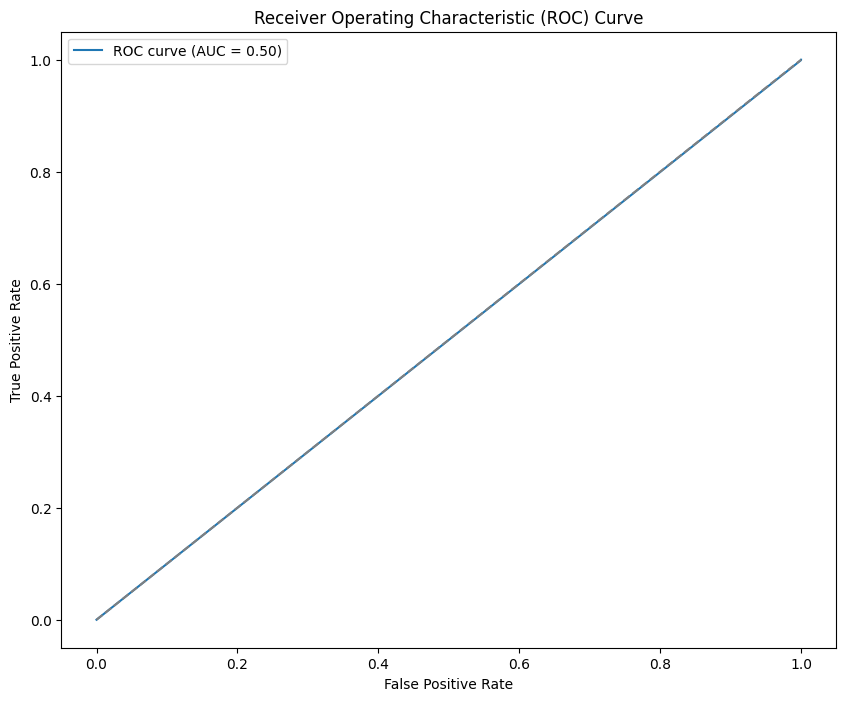

In [ ]:
# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [ ]:
# Confusion matrix
val_preds = (val_probs > 0.5).astype("int32")
cm = confusion_matrix(val_labels, val_preds)

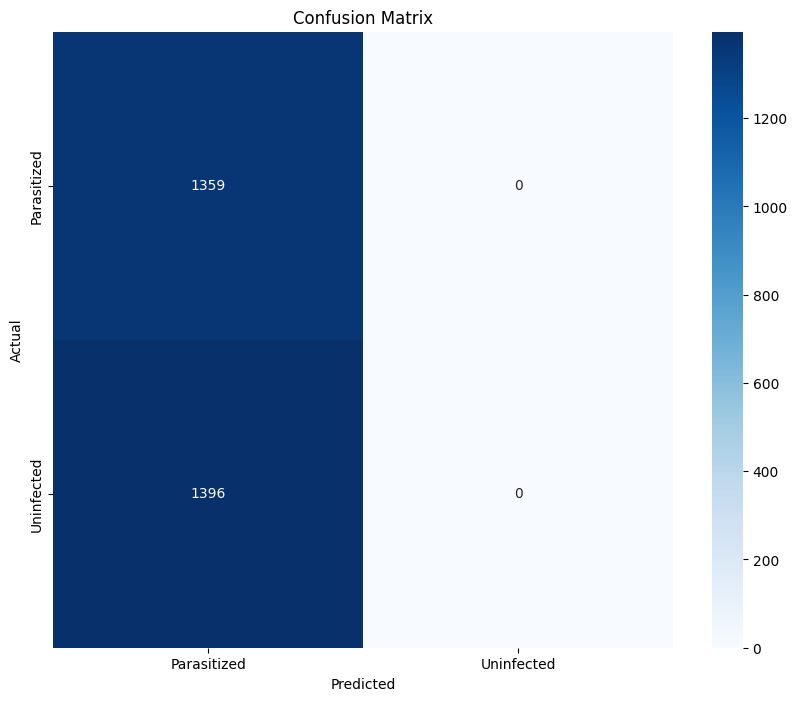

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Parasitized', 'Uninfected'], yticklabels=['Parasitized', 'Uninfected'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification report
print('Classification Report')
print(classification_report(val_labels, val_preds, target_names=['Parasitized', 'Uninfected']))


Classification Report
              precision    recall  f1-score   support

 Parasitized       0.49      1.00      0.66      1359
  Uninfected       0.00      0.00      0.00      1396

    accuracy                           0.49      2755
   macro avg       0.25      0.50      0.33      2755
weighted avg       0.24      0.49      0.33      2755



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


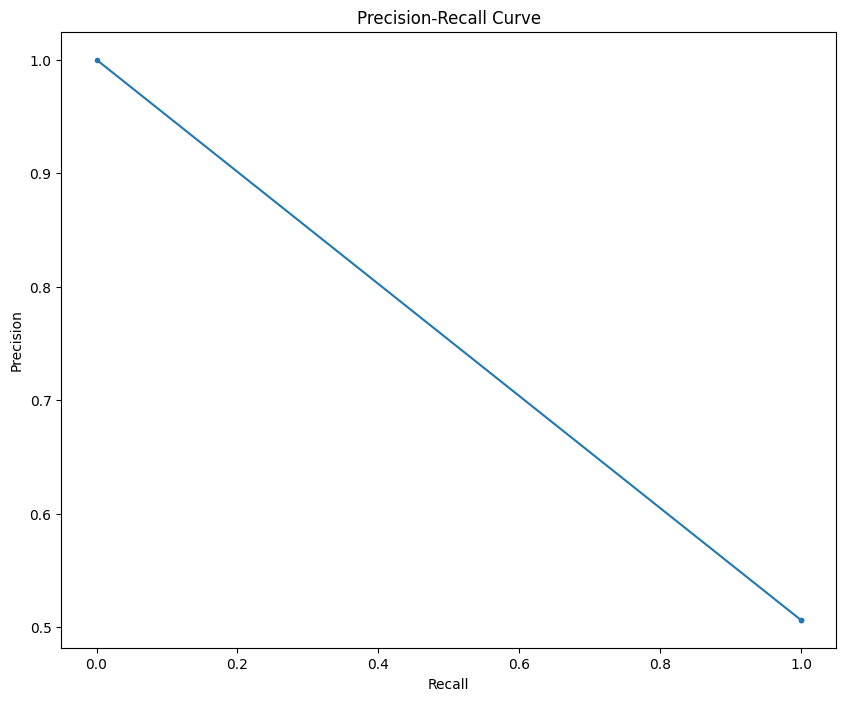

In [ ]:
# Precision-Recall curve
precision, recall, _ = precision_recall_curve(val_labels, val_probs)
plt.figure(figsize=(10, 8))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

1/1 [==============================] - 0s 29ms/step


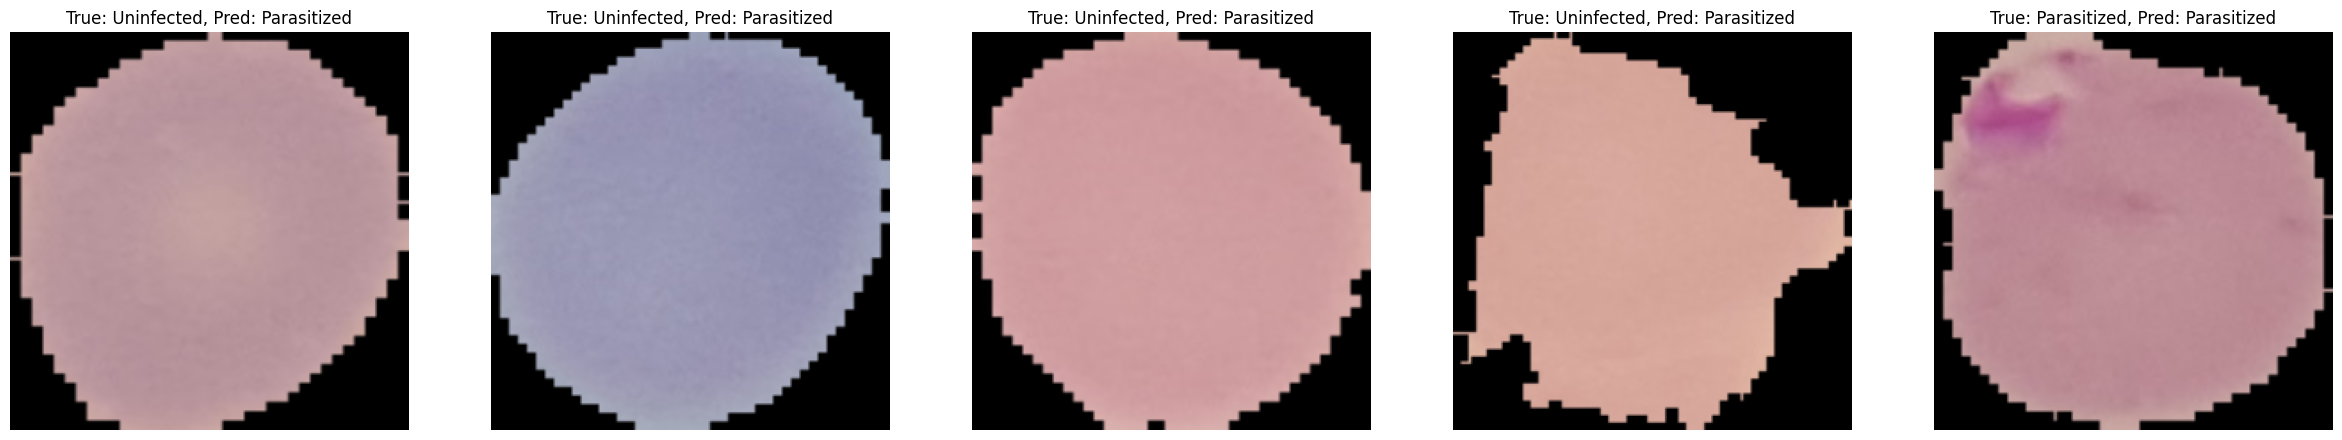

In [ ]:
# Predict on test dataset and visualize some predictions
def plot_predictions(model, dataset, class_names, num_images=5):
    plt.figure(figsize=(30, 30))
    for i, (image, label) in enumerate(dataset.take(num_images)):
        ax = plt.subplot(5, 5, i + 1)
        img_array = image.numpy()
        prediction = model.predict(tf.expand_dims(image, axis=0))[0][0]
        predicted_class = class_names[int(prediction > 0.5)]
        true_class = class_names[int(label)]
        plt.imshow(img_array)
        plt.title(f"True: {true_class}, Pred: {predicted_class}")
        plt.axis("off")

plot_predictions(lenet_model, test_dataset,['Parasitized', 'Uninfected'] )

Transfer Learning

In [ ]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# OLD
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNetV2
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNetV2 inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(1, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=config['LEARNING_RATE']),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)




16705208/16705208 [==============================] - 0s 0us/step
Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)


In [ ]:
model_0.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 1)                 1281      
                                                                 
Total params: 4050852 (15.45 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 4049571 (15.45 MB)
__________________

In [ ]:
# Train the model with early stopping and WandbCallback
history = model_0.fit(train_dataset,
                          validation_data=val_dataset,
                          epochs=config['N_EPOCHS'],
                          verbose=1,
                          callbacks=[early_stopping])

Epoch 1/100
689/689 [==============================] - 72s 94ms/step - loss: 0.6974 - accuracy: 0.5000 - val_loss: 0.6936 - val_accuracy: 0.5031
Epoch 2/100
689/689 [==============================] - 66s 96ms/step - loss: 0.6972 - accuracy: 0.5000 - val_loss: 0.6947 - val_accuracy: 0.5038
Epoch 3/100
689/689 [==============================] - 61s 88ms/step - loss: 0.6972 - accuracy: 0.5000 - val_loss: 0.6934 - val_accuracy: 0.5038
Epoch 4/100
689/689 [==============================] - 61s 88ms/step - loss: 0.6970 - accuracy: 0.5000 - val_loss: 0.6934 - val_accuracy: 0.5067
Epoch 5/100
689/689 [==============================] - 61s 88ms/step - loss: 0.6968 - accuracy: 0.5001 - val_loss: 0.6928 - val_accuracy: 0.5049
Epoch 6/100
689/689 [==============================] - 66s 96ms/step - loss: 0.6968 - accuracy: 0.5001 - val_loss: 0.6927 - val_accuracy: 0.5074
Epoch 7/100
689/689 [==============================] - 61s 88ms/step - loss: 0.6967 - accuracy: 0.5000 - val_loss: 0.6928 - val_ac

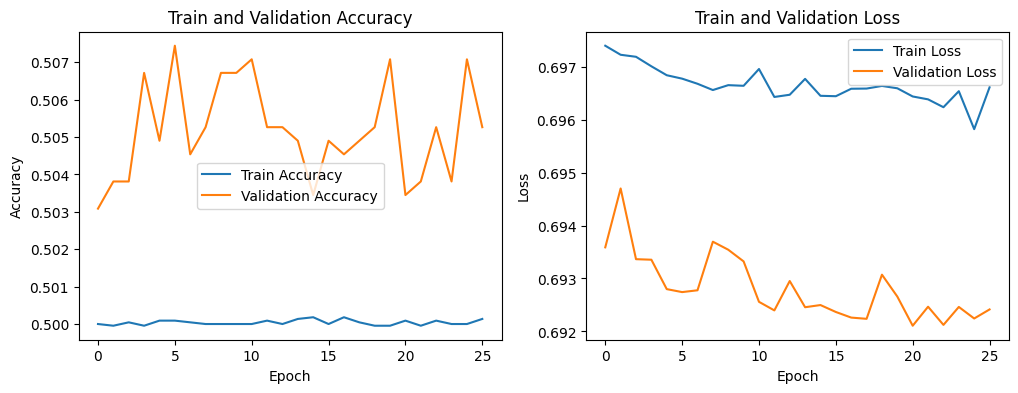

In [ ]:
# Plotting accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss')

plt.show()